# Purpose


This notebook demonstrates the data pipeline from raw tables to analytical datasets. At the end of this activity, train & test data sets are created from raw data.



## Imports

In [1]:
from pprint import pprint
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.options.mode.use_inf_as_na = True


In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, get_package_path,
    display_as_tabs, string_cleaning, merge_info, initialize_environment,
    list_datasets, load_dataset, save_dataset
)
import ta_lib.eda.api as eda

In [7]:
import warnings

warnings.filterwarnings('ignore', message="The default value of regex will change from True to False in a future version.", 
                        category=FutureWarning)

In [8]:
initialize_environment(debug=False, hide_warnings=True)

## Utility functions

# 1. Initialization

In [9]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)
pprint(list_datasets(context))

housing_df = load_dataset(context, '/raw/housing')

['/raw/housing',
 '/cleaned/housing',
 '/processed/housing',
 '/train/housing/features',
 '/train/housing/target',
 '/test/housing/features',
 '/test/housing/target',
 '/score/housing/output']


# 2. Data cleaning and consolidation

**<u>NOTES</u>**

The focus here is to create a cleaned dataset that is appropriate for solving the DS problem at hand from the raw data.

**1. Do**
* clean dataframe column names
* ensure dtypes are set properly
* join with other tables etc to create features
* transform, if appropriate, datetime like columns to generate additional features (weekday etc)
* transform, if appropriate, string columns to generate additional features
* discard cols that are not useful for training the model (IDs, constant cols, duplicate cols etc)
* additional features generated from existing columns


**2. Don't**
* handle missing values or outliers here. mark them and leave them for processing downstream.


## 2.1 Clean individual tables 

### Housing Table

From data discovery, we know the following

* Impute null values
* This will go into production code


In [10]:
housing_df_clean = (
    housing_df
    # while iterating on testing, it's good to copy the dataset(or a subset)
    # as the following steps will mutate the input dataframe. The copy should be
    # removed in the production code to avoid introducing perf. bottlenecks.
    .copy()

    # set dtypes : nothing to do here
    .passthrough()
    
    .replace({'': np.NaN})
    
    # ensure that the key column does not have duplicate records
    .remove_duplicate_rows(col_names=['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','median_house_value','ocean_proximity'], keep_first=True)
    
    # clean column names (comment out this line while cleaning data above)
    .clean_names(case_type='snake')
)
housing_df_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### NOTE

It's always a good idea to save cleaned tabular data using a storage format that supports the following 

1. preserves the type information
2. language agnostic storage format
3. Supports compression
4. Supports customizing storage to optimize different data access patterns

For larger datasets, the last two points become crucial.

`Parquet` is one such file format that is very popular for storing tabular data. It has some nice properties:
- Similar to pickles & RDS datasets, but compatible with all languages
- Preserves the datatypes
- Compresses the data and reduces the filesize
- Good library support in Python and other languages
- As a columnar storage we can efficiently read fewer columns
- It also supports chunking data by groups of columns (for instance, by dates or a particular value of a key column) that makes loading subsets of the data fast.

In [11]:
save_dataset(context, housing_df_clean, 'cleaned/housing')

In [12]:
housing_df_clean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


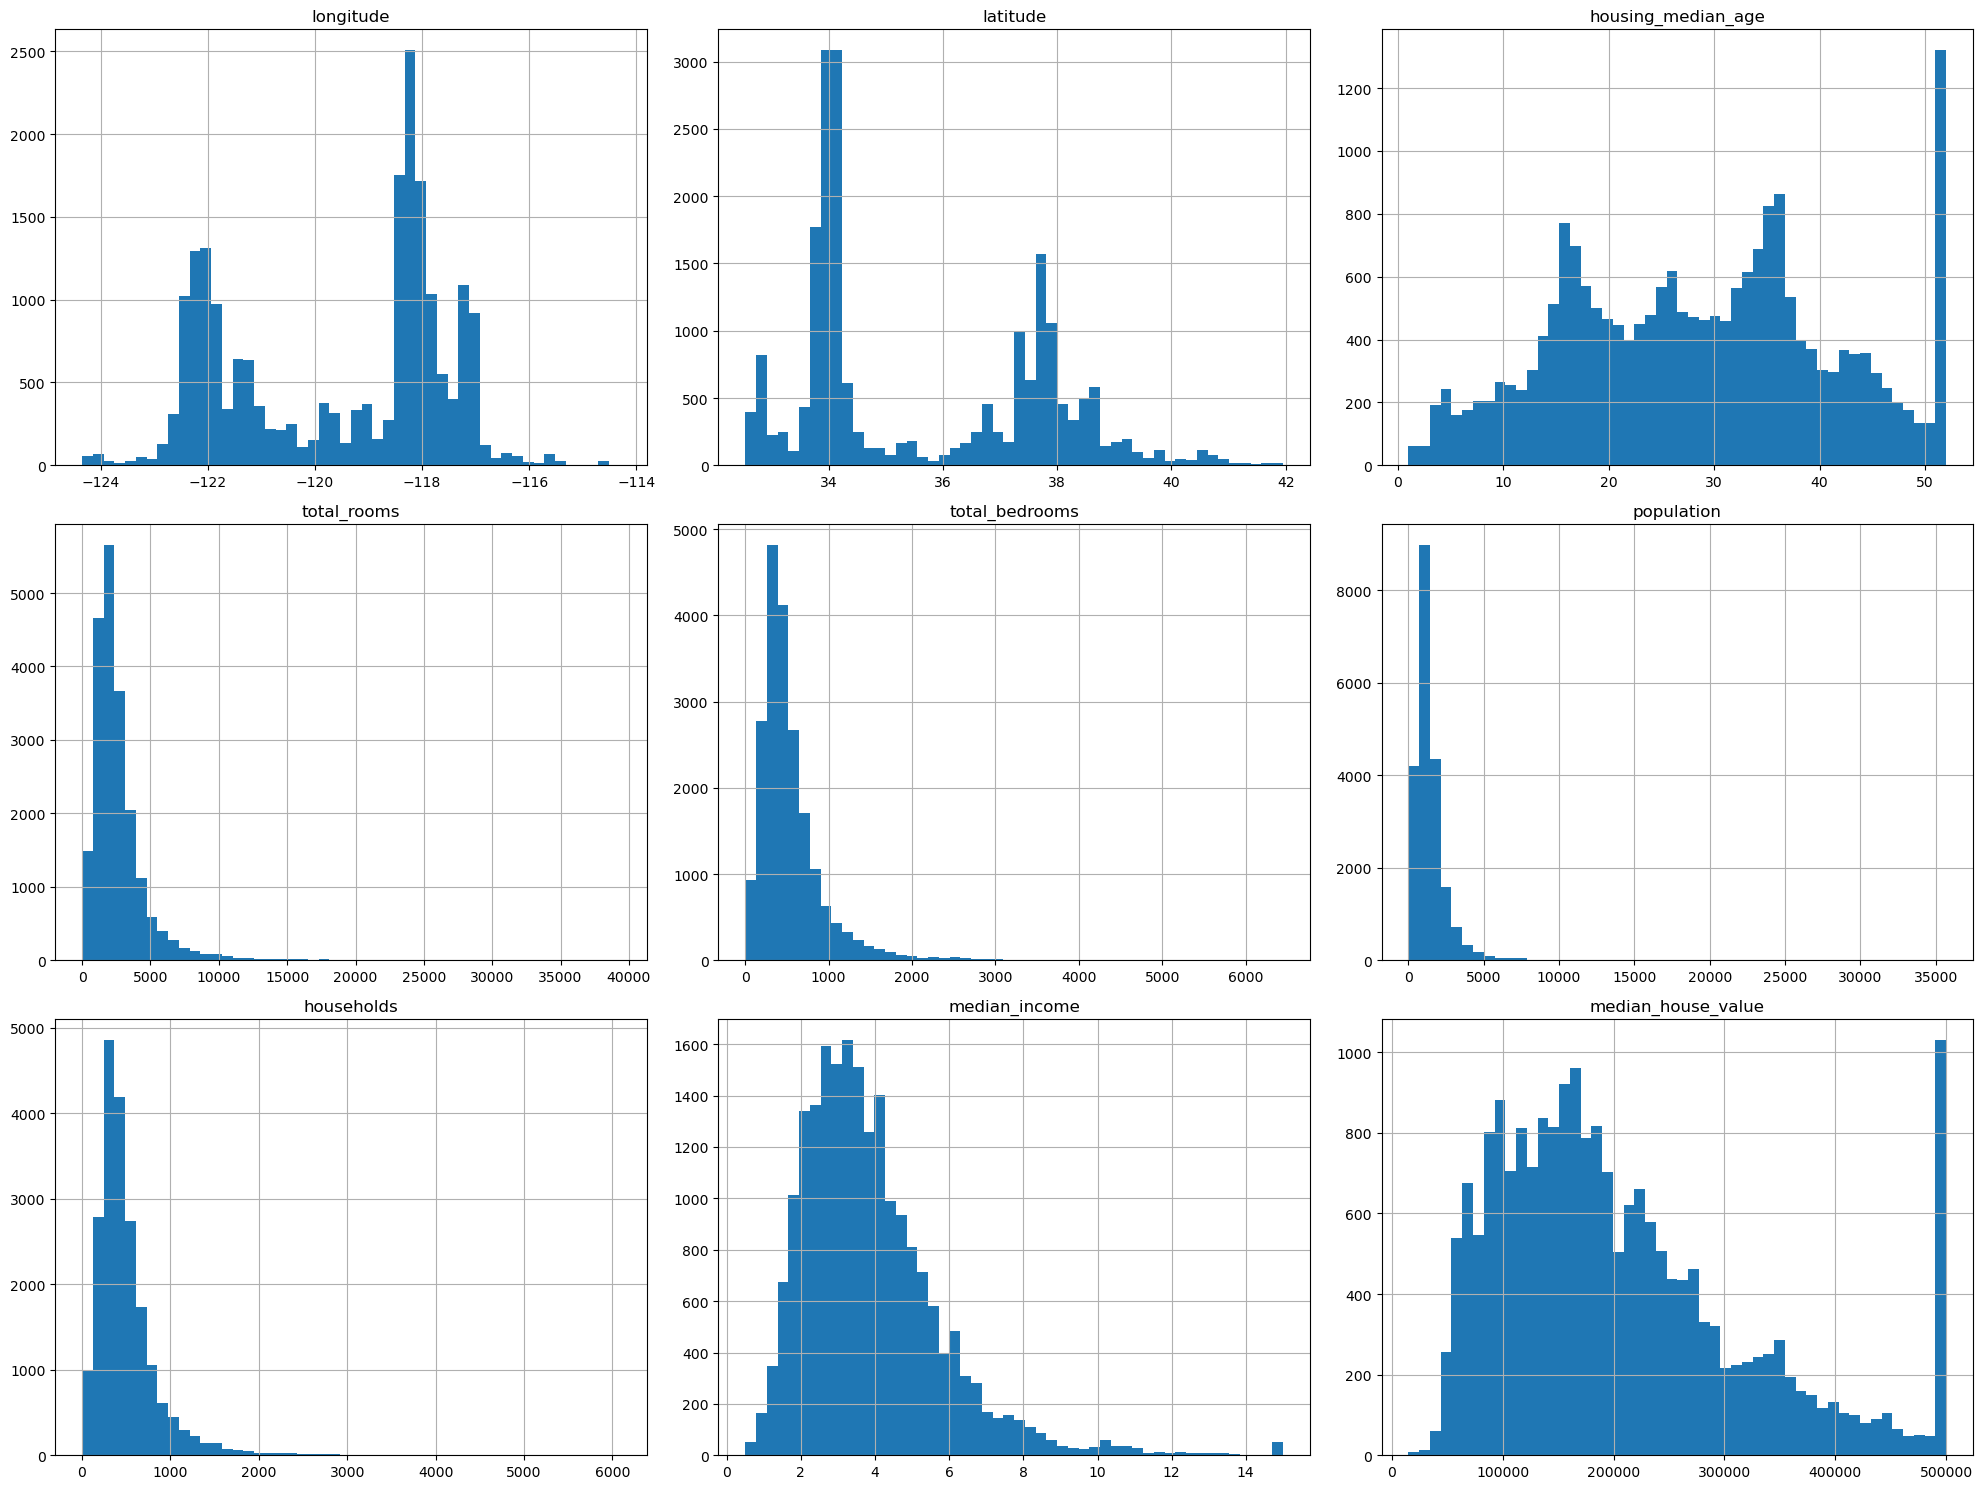

In [13]:
%matplotlib inline   
import matplotlib.pyplot as plt
housing_df_clean.hist(bins=50, figsize=(20,15))
plt.show()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


<Axes: xlabel='longitude', ylabel='latitude'>

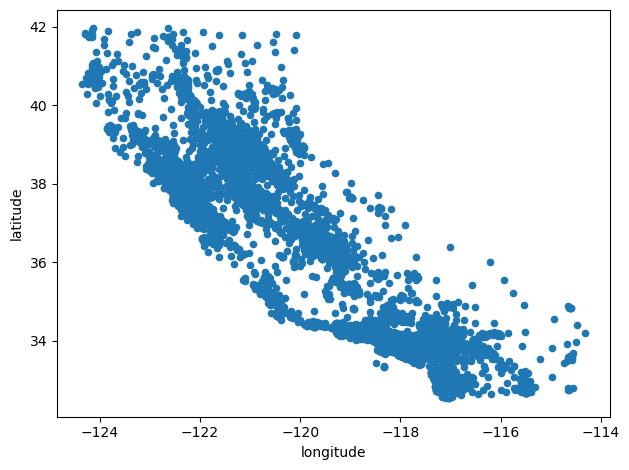

In [14]:
housing_df_clean.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

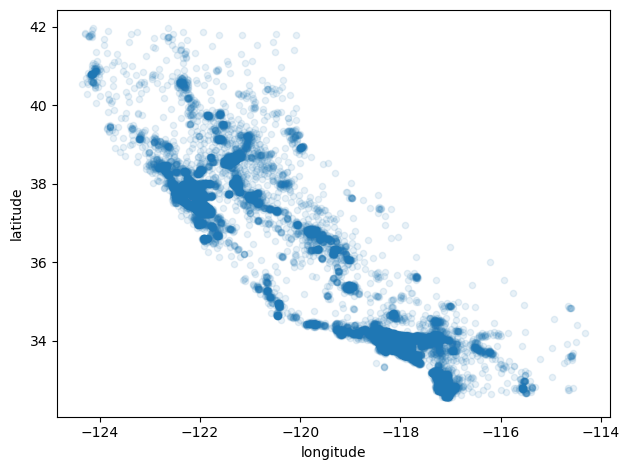

In [15]:
housing_df_clean.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

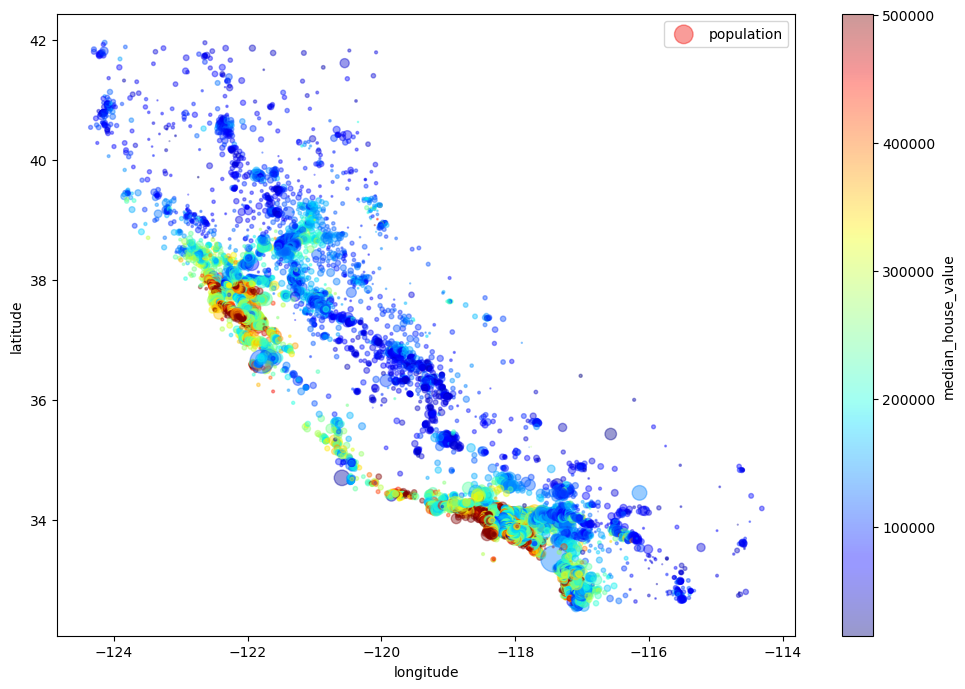

In [16]:
housing_df_clean.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_df_clean["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

This image indicates the relation b/w location and population density. Also, clustering algo would work better.

In [17]:
corr_matrix = housing_df_clean.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

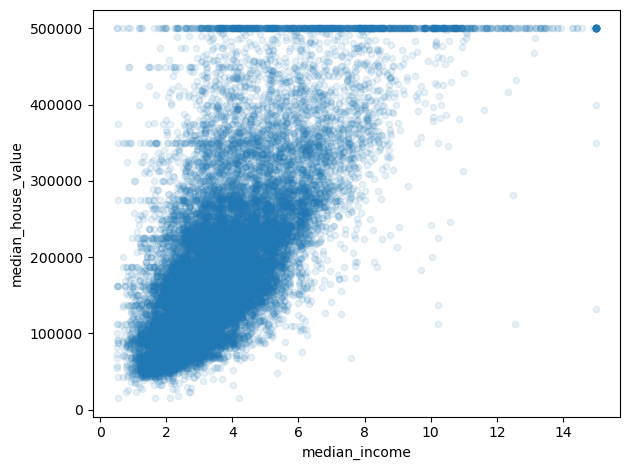

In [18]:
housing_df_clean.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

Here, the relation b/w income and house value makes sense. Also, can see house value is going flat at some points. We already knew higest pricing value is 500k but there are other two value points where it is flat - 350k and 450k.

In [19]:
# Any verifications on the data
from ta_lib.eda.api import get_variable_summary
display_as_tabs([
    ("Summary", f"Length: {len(housing_df_clean)}, Columns: {len(housing_df_clean.columns)}"),
    ("Variable summary", get_variable_summary(housing_df_clean)),
    ("head", housing_df_clean.head(5).T),
    ("tail", housing_df_clean.tail(5).T),
])

Tabs
    [0] Markdown(str, name='Summary')
    [1] DataFrame(height=300, name='Variable summary', sizing_mode='fixed', value=                         V..., width=800)
    [2] DataFrame(height=300, name='head', sizing_mode='fixed', value=              ..., width=800)
    [3] DataFrame(height=300, name='tail', sizing_mode='fixed', value=              ..., width=800)

# 3. Generate Train, Validation and Test datasets



- We split the data into train, test (optionally, also a validation dataset)
- In this example, we are binning the target into 5 quantiles basis income_cat and then use a Stratified Shuffle to split the data.
- See sklearn documentation on the various available splitters
- https://scikit-learn.org/stable/modules/classes.html#splitter-classes
- This will go into production code (training only)

<Axes: >

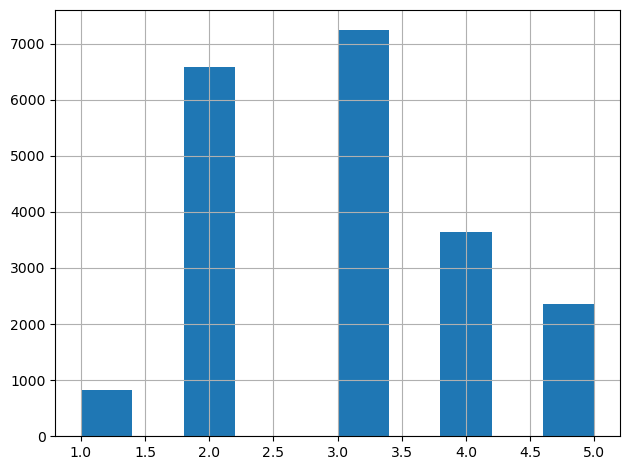

In [20]:
import numpy as np
housing_df_clean["income_cat"] = pd.cut(housing_df_clean["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing_df_clean["income_cat"].hist()

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
from ta_lib.core.api import custom_train_test_split  # helper function to customize splitting
from scripts import *

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=context.random_seed)
housing_df_train, housing_df_test = custom_train_test_split(housing_df_clean, splitter, by="income_cat")

In [22]:
housing_df_test["income_cat"].value_counts() / len(housing_df_test)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [23]:
housing_df_train["income_cat"].value_counts() / len(housing_df_train)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [24]:
for set_ in (housing_df_train, housing_df_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [25]:
target_col = "median_house_value"

train_X, train_y = (
    housing_df_train
    
    # split the dataset to train and test
    .get_features_targets(target_column_names=target_col)
)
save_dataset(context, train_X, 'train/housing/features')
save_dataset(context, train_y, 'train/housing/target')


test_X, test_y = (
    housing_df_test
    
    # split the dataset to train and test
    .get_features_targets(target_column_names=target_col)
)
save_dataset(context, test_X, 'test/housing/features')
save_dataset(context, test_y, 'test/housing/target')